# КОД

In [ ]:
import numpy as np
from scipy import sparse
from scipy.special import logsumexp, expit


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        to_exp = np.vstack((np.zeros(len(y)), -1 * X @ w * y)).T
        sum_ans = np.sum(logsumexp(to_exp, axis=1)) / len(y)
        return sum_ans + self.l2_coef * w @ w * 0.5

    def grad(self, X, y, w):
        min_val = np.finfo(np.dtype(np.float64)).min
        max_val = np.finfo(np.dtype(np.float64)).max
        if isinstance(X, sparse.csr_matrix):
            to_exp = -1 * np.asarray(X @ w) * y
            diff = np.clip(np.exp(to_exp), min_val, max_val)
            sum_answ = np.asarray(-1 * X.multiply(y[:, np.newaxis]).multiply((diff * expit(-1 * to_exp))[:, np.newaxis]).sum(axis=0))
            return np.squeeze(sum_answ, axis=0) / len(y) + self.l2_coef * w
        to_exp = -1 * X @ w * y
        diff = np.clip(np.exp(to_exp), min_val, max_val)
        sum_answ = np.sum((diff * expit(-1 * to_exp))[:, np.newaxis] * -1 * X * y[:, np.newaxis], axis=0)
        return sum_answ / len(y) + self.l2_coef * w


In [ ]:
import numpy as np
from scipy import sparse
from scipy.special import expit
from time import time


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
            self, loss_function, step_alpha=1, step_beta=0,
            tolerance=1e-5, max_iter=1000, **kwargs
    ):
        self.history = {'time': [0.0], 'func': [], 'acc': [], 'plot_time': [0.0]}
        self.oracle = None
        self.loss_func = loss_function
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.w = None

    def fit(self, X, y, w_0=None, trace=False, if_acc=False, X_test=None, y_test=None):
        """
        Добавлены аргументы if_acc=False, X_test=None, y_test=None
        для того, чтобы считать точность и сохранять в history
        """
        if w_0 is None:
            curr_w = np.zeros(X.shape[1])
        else:
            curr_w = w_0.copy()
        if self.loss_func == 'binary_logistic':
            self.oracle = BinaryLogistic(**self.kwargs)
        else:
            raise NotImplementedError('Only binary_logistic is implemented')
        self.w = curr_w.copy()
        self.history['func'].append(self.oracle.func(X, y, curr_w))
        self.history['acc'].append(np.sum(np.equal(y_test,
                                                               self.predict(X_test))) / np.size(y_test))
        last_func = self.oracle.func(X, y, curr_w)
        curr_func = last_func
        k = 1
        start_time = time()
        prev_time = start_time
        while (np.abs(curr_func - last_func) >= self.tolerance and k < self.max_iter + 1) or k == 1:
            k += 1
            gw = self.oracle.grad(X, y, curr_w)
            eta = self.alpha / (k ** self.beta)
            curr_w = curr_w - eta * gw
            self.w = curr_w.copy()
            last_func = curr_func.copy()
            curr_func = self.oracle.func(X, y, curr_w)
            end_time = time()
            if trace:
                self.history['plot_time'].append(end_time - start_time)
                self.history['time'].append(end_time - prev_time)

                self.history['func'].append(curr_func)
                if if_acc:
                    self.history['acc'].append(np.sum(np.equal(y_test,
                                                               self.predict(X_test))) / np.size(y_test))

            prev_time = end_time
        self.w = curr_w.copy()
        if trace:
            return self.history

    def predict(self, X):
        probs = self.predict_proba(X)[:, 1]
        return np.where(probs >= 0.5, 1, -1)

    def predict_proba(self, X):
        if isinstance(X, sparse.csr_matrix):
            probabil = expit(np.asarray(X @ self.w))
            return np.vstack([1 - probabil, probabil]).T
        probabil = expit(X @ self.w)
        return np.vstack([1 - probabil, probabil]).T

    def get_objective(self, X, y):
        return self.oracle.func(X, y, self.w)

    def get_gradient(self, X, y):
        return self.oracle.grad(X, y, self.w)

    def get_weights(self):
        return self.w


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
            self, loss_function, batch_size, step_alpha=1, step_beta=0,
            tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs
    ):
        self.history = {'epoch_num': [0.0], 'time': [0.0], 'func': [], 'weights_diff': [0.0], 'plot_time': [0.0],
                        'acc': []}
        self.loss_func = loss_function
        self.batch_size = batch_size
        self.alpha = step_alpha
        self.beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_seed = random_seed
        self.kwargs = kwargs
        self.w = None
    def predict(self, X):
      return super().predict(X)
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, if_acc=False, X_test=None, y_test=None):

        np.random.seed(self.random_seed)

        if w_0 is None:
            curr_w = np.zeros(X.shape[1])
        else:
            curr_w = w_0

        if self.loss_func == 'binary_logistic':
            self.oracle = BinaryLogistic(self.kwargs['l2_coef'])
        else:
            raise NotImplementedError('Only binary_logistic is implemented')
        self.w = curr_w.copy()
        if trace:
            self.history['func'].append(self.oracle.func(X, y, curr_w))
        if if_acc:
            self.history['acc'].append(np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test))
        start_time = time()
        prev_time = start_time
        prev_loss = self.history['func'][0]
        prev_w = curr_w.copy()

        cur_loss = prev_loss + self.tolerance

        objects = 0
        flag = False

        for k in range(1, self.max_iter + 1):
            self.indexes = np.arange(X.shape[0])
            np.random.shuffle(self.indexes)
            eta = self.alpha / (k ** self.beta)
            prev_epoch = 0
            objects = 0
            for j in range(0, X.shape[0], self.batch_size):
                new_time = time()

                cur_indexes = self.indexes[j:j + self.batch_size]
                objects += len(cur_indexes)

                cur_epoch = objects / X.shape[0]
                gw = self.oracle.grad(X[cur_indexes], y[cur_indexes], curr_w)
                curr_w = curr_w - eta * gw
                self.w = curr_w.copy()

                if np.abs(cur_epoch - prev_epoch) > log_freq:

                    prev_epoch = cur_epoch
                    cur_loss = self.oracle.func(X, y, curr_w)
                    if trace:
                        self.history['time'].append(new_time - prev_time)
                        self.history['plot_time'].append(prev_time - start_time)
                        self.history['epoch_num'].append(cur_epoch)
                        self.history['weights_diff'].append((curr_w - prev_w) @ (curr_w - prev_w).T)
                        self.history['func'].append(cur_loss)
                        if if_acc:
                            self.history['acc'].append(np.sum(np.equal(y_test, self.predict(X_test))) / np.size(y_test))
                        prev_w = curr_w.copy()
                        self.w = curr_w.copy()

                    if np.abs(prev_loss - cur_loss) < self.tolerance:
                        flag = True
                        break
                prev_time = new_time
                prev_loss = cur_loss.copy()
            if flag:
                break

        self.w = curr_w.copy()
        if trace:
            return self.history








In [ ]:
import numpy as np

def grad_finite_diff(function, w, eps=1e-8):
    result = []
    for i in range (len(w)):
        e_i = np.zeros(len(w))
        e_i[i] = 1
        result_i = (function(w + eps * e_i) - function(w)) / eps
        result.append(result_i)
    return result

### Подготовка данных


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [ ]:
!pip install gdown

import gdown
url ='https://www.dropbox.com/scl/fi/gg5duoz5ukbgy06b9u10a/toxic_test.csv?rlkey=d9zoojwl6tit7cod8ryraaanj&dl=1'

output = 'test.csv'

gdown.download(url, output, quiet=False)

Downloading...
From: https://www.dropbox.com/scl/fi/gg5duoz5ukbgy06b9u10a/toxic_test.csv?rlkey=d9zoojwl6tit7cod8ryraaanj&dl=1
To: /content/test.csv
100%|██████████| 7.73M/7.73M [00:00<00:00, 45.1MB/s]


'test.csv'

In [ ]:
!pip install gdown

import gdown
url ='https://www.dropbox.com/scl/fi/5oyy1ursg5ptxksv3c6h6/toxic_train.csv?rlkey=7nz8mt8kod88rhlk8ab59y517&dl=1'

output = 'train.csv'

gdown.download(url, output, quiet=False)

Downloading...
From: https://www.dropbox.com/scl/fi/5oyy1ursg5ptxksv3c6h6/toxic_train.csv?rlkey=7nz8mt8kod88rhlk8ab59y517&dl=1
To: /content/train.csv
100%|██████████| 20.4M/20.4M [00:02<00:00, 8.39MB/s]


'train.csv'

#  1.Предварительная обработка текста

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
train_data = pd.read_csv('train.csv', index_col=0)
train_data.head(10)

comment_text  \
0                                                                                                                                                                                                                                                                                                                                                                           Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)   
2                                                                                                                                                                                                                                                                                                                                                                                                           Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.   
3  "\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 You, sir, are my hero. Any chance you remember what page that's on?   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 "\n\nCongratulations from me as well, use the tools well.  · talk "   
6                                                                                                                                                                                         

In [ ]:
test_data = pd.read_csv('test.csv', index_col=0)
test_data.head(10)

comment_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                              Thank you for understanding. I think very highly of you and would not revert without discussion.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              :Dear god this site is horrible.   
2                                                           "::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \n\n "   
3  " \n\n It says it right there that it IS a type. The ""Type"" of institution is needed in this case because there are three levels of SUNY schools: \n -University Centers and Doctoral Granting Institutions \n -State Colleges \n -Community Colleges. \n\n It is needed in this case to clarify that UB is a SUNY Center. It says it even in Binghamton University, University at Albany, State University of New York, and Stony Brook University. Stop trying to say it's not because I am totally right in this case."   
4                                                                                                                                                                           " \n\n == Before adding a new product to the list, make sure it's relevant == \n\n Before adding a new product to the list, make sure it has a wikipedia entry already, ""proving"" it's relevance and giving the reader the possibility to read more about it. \n Otherwise it could be subject to deletion. See this article's revision history."   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      this other one from 1897   
6                                                                                                                                                                                                                                                                                                                                                             == Reason for banning throwing == \n\n This article needs a section on /why/ throwing is banned. At the moment, to a non-cricket fan, it seems kind of arbitrary.   
7                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
train_data.iloc[:,0].head(3)

0    Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
1                                                                                                                                                             D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
2                                    Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Name: comment_text, dtype: object

In [ ]:
test_data.iloc[:,0].head(3)

0                                                                                                                                                                                                                                                                                                                                                                       Thank you for understanding. I think very highly of you and would not revert without discussion.
1                                                                                                                                                                                                                                                                                                                                                                                                                                       :Dear god this site is horrible.
2    "::: Somebody will invariably try to add Religion?  Really??  You mean, the way p

In [ ]:
import re


def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', text)

    return text.strip()

In [ ]:
train_data.iloc[:,0] = train_data.iloc[:,0].apply(preprocess_text)

In [ ]:
test_data.iloc[:,0] = test_data.iloc[:,0].apply(preprocess_text)

In [ ]:
train_data.iloc[:,0].head(3)

0    explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now 89 205 38 27
1                                                                                                                                                             d aww  he matches this background colour i m seemingly stuck with  thanks    talk  21 51  january 11  2016  utc
2                                    hey man  i m really not trying to edit war  it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page  he seems to care more about the formatting than the actual info
Name: comment_text, dtype: object

In [ ]:
test_data.iloc[:,0].head(3)

0                                                                                                                                                                                                                                                                                                                                                       thank you for understanding  i think very highly of you and would not revert without discussion
1                                                                                                                                                                                                                                                                                                                                                                                                                        dear god this site is horrible
2    somebody will invariably try to add religion   really    you mean  the way people have invariably kept adding   rel

In [ ]:
train_data

comment_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now 89 205 38 27   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               d aww  he matches this background colour i m seemingly stuck with  thanks    talk  21 51  january 11  2016  utc   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
target_train = train_data['is_toxic'].copy()
train = train_data.drop('is_toxic', axis=1)

In [ ]:
target_test = test_data['is_toxic'].copy()

In [ ]:
# => (0,1) -> (-1,1)
target_train = target_train.values.astype(int) * 2 - 1
target_test = target_test.values.astype(int) * 2 - 1

# 2.Преобразование в разреженную матрицу

In [ ]:
train.shape

(52061, 1)

так как всего 52061 комментариев в тренировочной выборке, а токсичных из них 16225

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

In [ ]:
from sklearn.model_selection import train_test_split

X_train_m, X_test_m, y_train, y_test = train_test_split(train, target_train, train_size=0.7, random_state=241)
vectorizer = CountVectorizer(min_df=0.01)
X_train = vectorizer.fit_transform(X_train_m['comment_text'])
X_test = vectorizer.transform(X_test_m['comment_text'])

In [ ]:
X_train

<36442x572 sparse matrix of type '<class 'numpy.int64'>'
	with 924080 stored elements in Compressed Sparse Row format>

In [ ]:
len(vectorizer.get_feature_names_out())


572

In [ ]:
X_train_m.shape

(36442, 1)

In [ ]:
X_test_m.shape

(15619, 1)

# 3.Сравнение численного подхода и аналитичного

In [ ]:
np.random.seed(42)
oracle = BinaryLogistic(l2_coef= 0.01)
w = np.random.random(X_train.shape[1])

In [ ]:
%%time
grad_oracle = oracle.grad(X_train, y_train, w)

CPU times: user 64.6 ms, sys: 18 ms, total: 82.7 ms
Wall time: 83.8 ms


In [ ]:
oracle.func(X_train, y_train, w)

17.904568227134906

In [ ]:
%%time
from functools import partial

partial_func = partial(oracle.func, X_train, y_train)
grad_utils = grad_finite_diff(partial_func, w)

CPU times: user 9.88 s, sys: 25.2 ms, total: 9.91 s
Wall time: 14.3 s


In [ ]:
difference_norm = np.linalg.norm(np.array(grad_utils) - np.array(grad_oracle))
print(f"Norm of the difference: {difference_norm:.10f}")

Norm of the difference: 0.0000053689


In [ ]:
MAE = np.mean(np.abs(np.array(grad_utils)) - np.abs(np.array(grad_oracle)))
print(f"MAE of the difference: {MAE:.10f}")

MAE of the difference: 0.0000000406


# 4.Исследование поведения градиентного спуска

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

<ipython-input-36-e8eca9cac5c4>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [ ]:
import numpy as np

### всевозможны комбинации

In [ ]:
l2_coef = 0.01
num_size = X_train.shape[1]
step_alphas = [0.01, 0.1, 1.0, 3.0]
step_betas = [2 ** i for i in range(-2,2)]
w_0_types = [np.zeros(num_size), np.random.uniform(-1/num_size, 1/num_size, num_size), np.random.normal(0, 1/num_size, num_size)]
w_0_names = ['w_0 ~ [0...0]','w_0 ~ U(-1/d 1/d), d=shape(X)', 'w_0 ~ N(0,1)']

In [ ]:
from itertools import product
all_combinations = list(product(step_alphas, step_betas,))

In [ ]:
l2_coef = 0.01
all_history_gd = dict()
num_size = X_train.shape[1]
step_alphas = [0.01, 0.1, 1.0, 3.0]
step_betas = [2 ** i for i in range(-2,2)]
w_0_types = [np.zeros(num_size), np.random.uniform(-1/num_size, 1/num_size, num_size), np.random.normal(0, 1/num_size, num_size)]
all_history_gd = dict()
for alpha in step_alphas:
  all_history_gd[alpha] = dict()
  for i in range(len(w_0_types)):
    all_history_gd[alpha][i] = dict()
    for beta in step_betas:
        model = GDClassifier(loss_function='binary_logistic', step_alpha=alpha, step_beta=beta, max_iter=100, l2_coef=l2_coef)
        all_history_gd[alpha][i][beta]  = dict()
        all_history_gd[alpha][i][beta]= model.fit(X_train, y_train, w_0=w_0_types[i], trace=True, if_acc=True, X_test=X_test, y_test=y_test)
        print(f"alpha={alpha}, {w_0_names[i]}, beta={beta}")

alpha=0.01, w_0 ~ [0...0], beta=0.25
alpha=0.01, w_0 ~ [0...0], beta=0.5
alpha=0.01, w_0 ~ [0...0], beta=1
alpha=0.01, w_0 ~ [0...0], beta=2
alpha=0.01, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.25
alpha=0.01, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.5
alpha=0.01, w_0 ~ U(-1/d 1/d), d=shape(X), beta=1
alpha=0.01, w_0 ~ U(-1/d 1/d), d=shape(X), beta=2
alpha=0.01, w_0 ~ N(0,1), beta=0.25
alpha=0.01, w_0 ~ N(0,1), beta=0.5
alpha=0.01, w_0 ~ N(0,1), beta=1
alpha=0.01, w_0 ~ N(0,1), beta=2
alpha=0.1, w_0 ~ [0...0], beta=0.25
alpha=0.1, w_0 ~ [0...0], beta=0.5
alpha=0.1, w_0 ~ [0...0], beta=1
alpha=0.1, w_0 ~ [0...0], beta=2
alpha=0.1, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.25
alpha=0.1, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.5
alpha=0.1, w_0 ~ U(-1/d 1/d), d=shape(X), beta=1
alpha=0.1, w_0 ~ U(-1/d 1/d), d=shape(X), beta=2
alpha=0.1, w_0 ~ N(0,1), beta=0.25
alpha=0.1, w_0 ~ N(0,1), beta=0.5
alpha=0.1, w_0 ~ N(0,1), beta=1
alpha=0.1, w_0 ~ N(0,1), beta=2
alpha=1.0, w_0 ~ [0...0], beta=0.25
alpha=1.0,

<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


alpha=3.0, w_0 ~ [0...0], beta=0.25
alpha=3.0, w_0 ~ [0...0], beta=0.5
alpha=3.0, w_0 ~ [0...0], beta=1
alpha=3.0, w_0 ~ [0...0], beta=2
alpha=3.0, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.25
alpha=3.0, w_0 ~ U(-1/d 1/d), d=shape(X), beta=0.5
alpha=3.0, w_0 ~ U(-1/d 1/d), d=shape(X), beta=1
alpha=3.0, w_0 ~ U(-1/d 1/d), d=shape(X), beta=2
alpha=3.0, w_0 ~ N(0,1), beta=0.25
alpha=3.0, w_0 ~ N(0,1), beta=0.5
alpha=3.0, w_0 ~ N(0,1), beta=1
alpha=3.0, w_0 ~ N(0,1), beta=2


### Все итерации и функция потерь

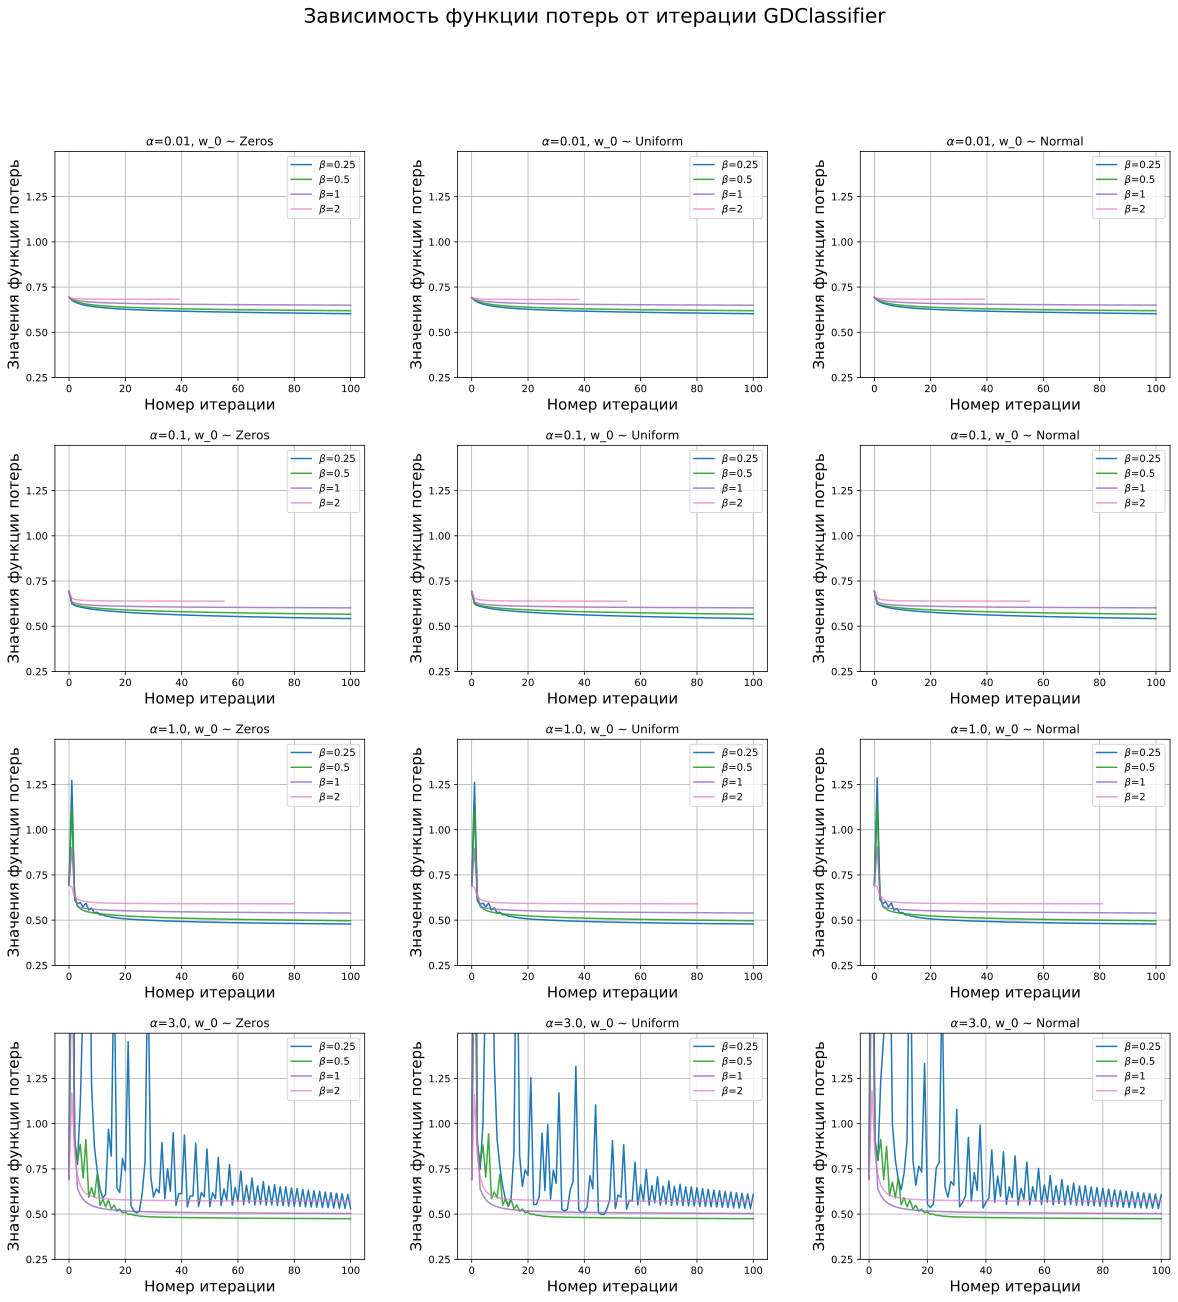

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 3, figsize=(3,3))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость функции потерь от итерации GDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, w_0_name in enumerate(w_0_names):
    for j, beta in enumerate(step_betas):
        ax[i,k].plot(all_history_gd[alpha][k][beta]['func'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_name)
    ax[i,k].set_xlabel('Номeр итерации', fontsize=15)
    ax[i,k].set_ylabel('Значения функции потерь', fontsize=15)
    ax[i,k].set_ylim([0.25,1.5])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.25, 1.5, 0.25))

plt.margins(x=0.03, y=0.03)
plt.savefig("e_4_los_it.svg", bbox_inches='tight')
plt.show()

### Избранное итерации и функция потерь

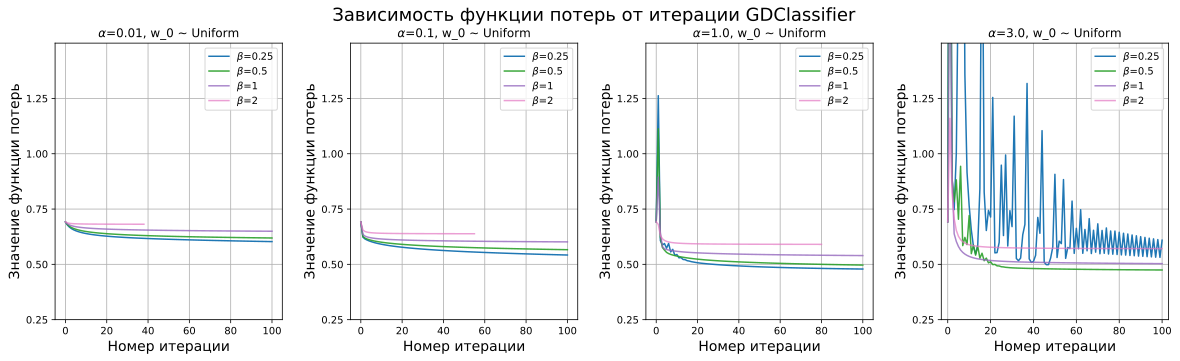

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(3,3))
fig.set_size_inches(20, 5)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость функции потерь от итерации GDClassifier', fontsize=18)
for i, alpha in enumerate(step_alphas):
    for j, beta in enumerate(step_betas):
        ax[i].plot(all_history_gd[alpha][1][beta]['func'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i].legend()
    ax[i].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_names[1])
    ax[i].set_xlabel('Номeр итерации',fontsize=14)
    ax[i].set_ylabel('Значение функции потерь',fontsize=14)
    ax[i].set_ylim([0.25,1.5])
    ax[i].grid(True)
    ax[i].set_yticks(np.arange(0.25, 1.5, 0.25))

plt.margins(x=0.03, y=0.03)
plt.savefig("e_4_loss_it_fix.svg", bbox_inches='tight')
plt.show()

### Все время и функция потерь

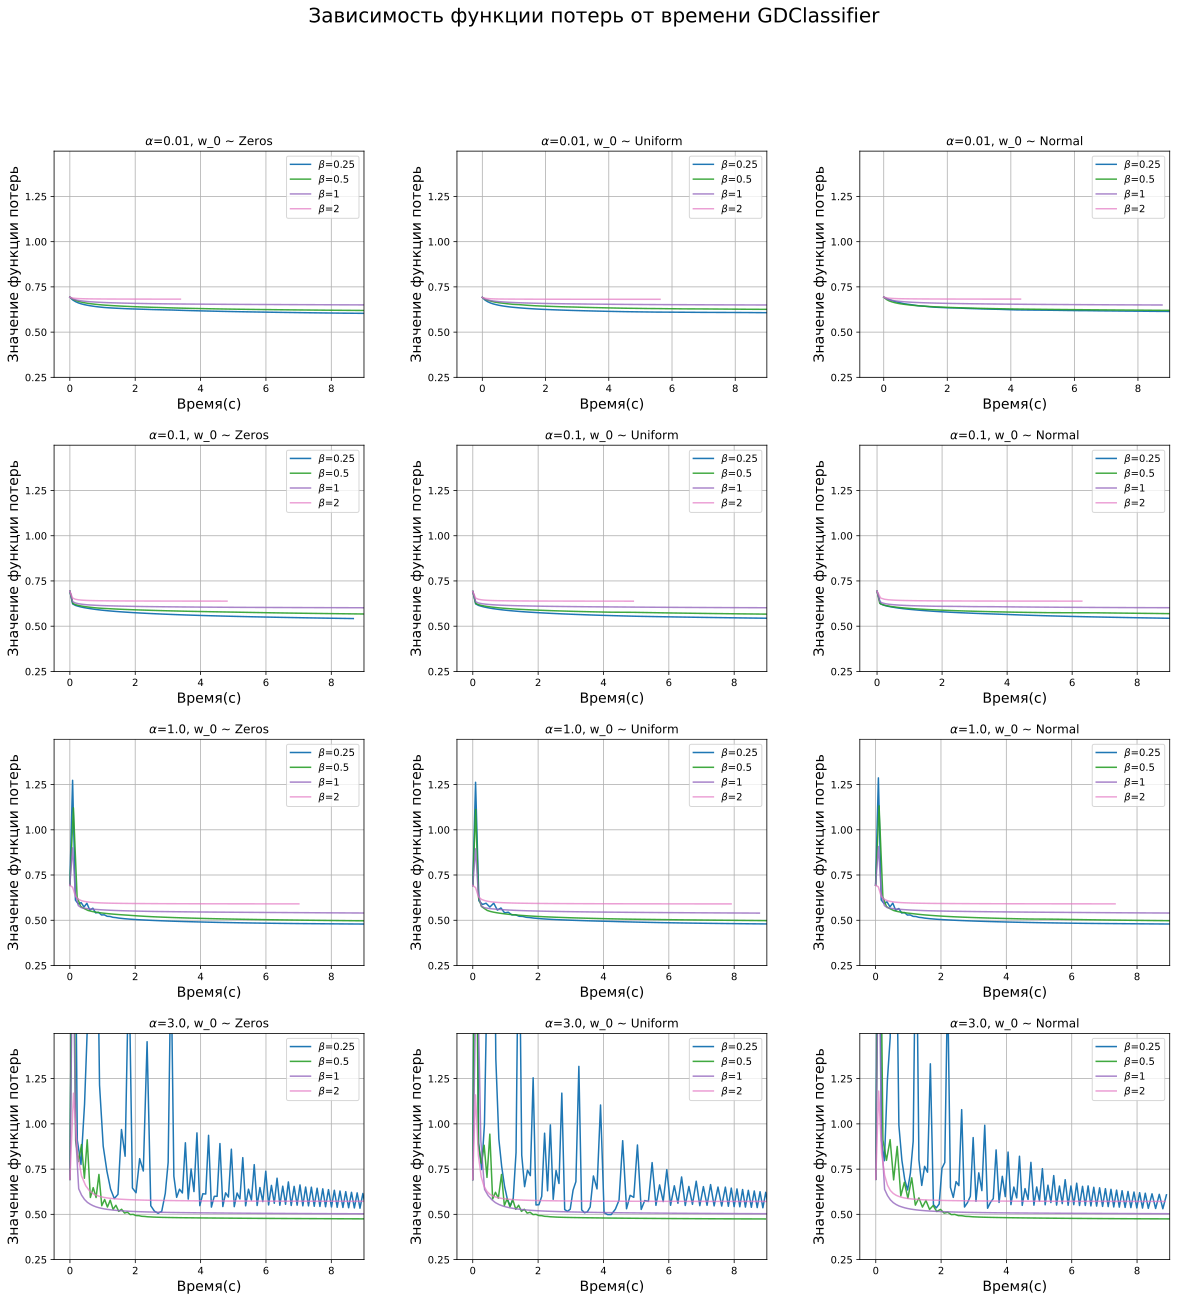

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 3, figsize=(3,4))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость функции потерь от времени GDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, w_0_name in enumerate(w_0_names):
    for j, beta in enumerate(step_betas):
        ax[i,k].plot(all_history_gd[alpha][k][beta]['plot_time'], all_history_gd[alpha][k][beta]['func'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_name)
    ax[i,k].set_xlabel('Время(с)',fontsize=14)
    ax[i,k].set_ylim([0.25,1.5])
    ax[i,k].set_xlim(xmax=9)
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.25, 1.5, 0.25))
    ax[i,k].set_ylabel('Значение функции потерь',fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_4_loss_time.svg", bbox_inches='tight')
plt.show()

### Все итерации и точность

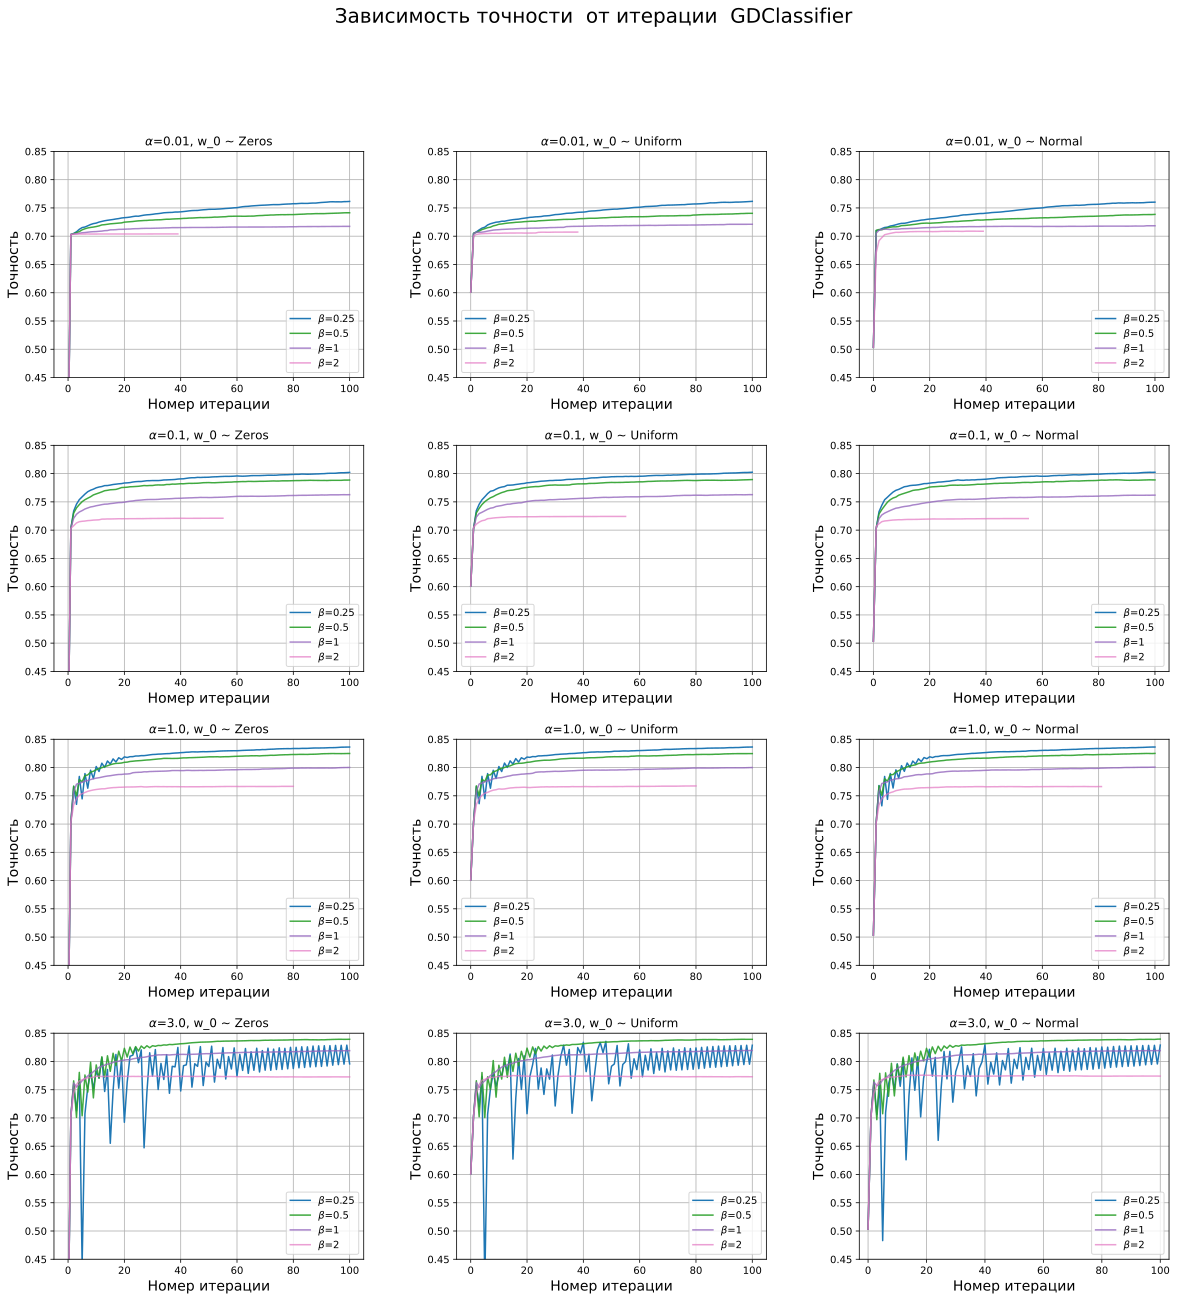

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 3, figsize=(3,4))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость точности  от итерации  GDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, w_0_name in enumerate(w_0_names):
    for j, beta in enumerate(step_betas):
        ax[i,k].plot(all_history_gd[alpha][k][beta]['acc'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_name,fontsize=14)
    ax[i,k].set_xlabel('Номeр итерации',fontsize=14)
    ax[i,k].set_ylim([0.45,0.85])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.45, 0.9, 0.05))
    ax[i,k].set_ylabel('Точность',fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_4_acc_it.svg", bbox_inches='tight')
plt.show()

### Избранное итерации и точность

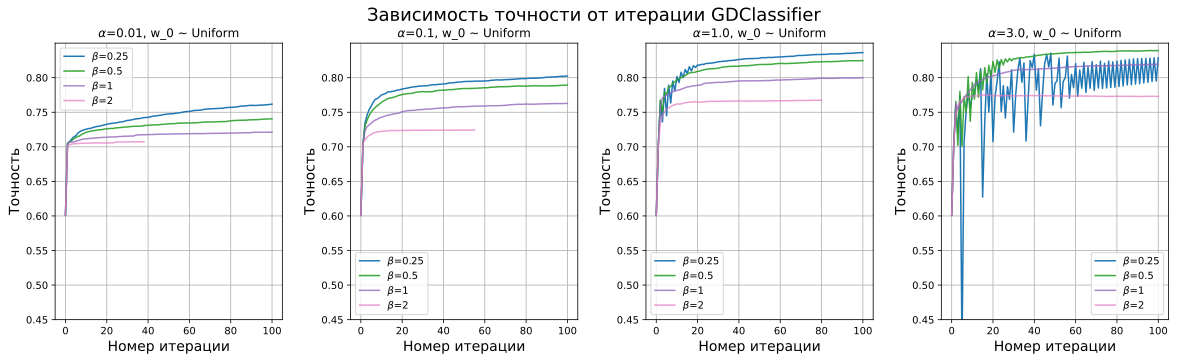

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость точности от итерации GDClassifier', fontsize=18)
for i, alpha in enumerate(step_alphas):
    for j, beta in enumerate(step_betas):
        ax[i].plot(all_history_gd[alpha][1][beta]['acc'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i].legend()
    ax[i].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_names[1])
    ax[i].set_ylabel('Точность',fontsize=14)
    ax[i].set_xlabel('Номeр итерации',fontsize=14)
    ax[i].set_ylim([0.45,0.85])
    ax[i].grid(True)
    ax[i].set_yticks(np.arange(0.45, 0.85, 0.05))

plt.margins(x=0.05, y=0.05)
plt.savefig("e_4_acc_it_fix.svg", bbox_inches='tight')
plt.show()

### Все итерации и точность

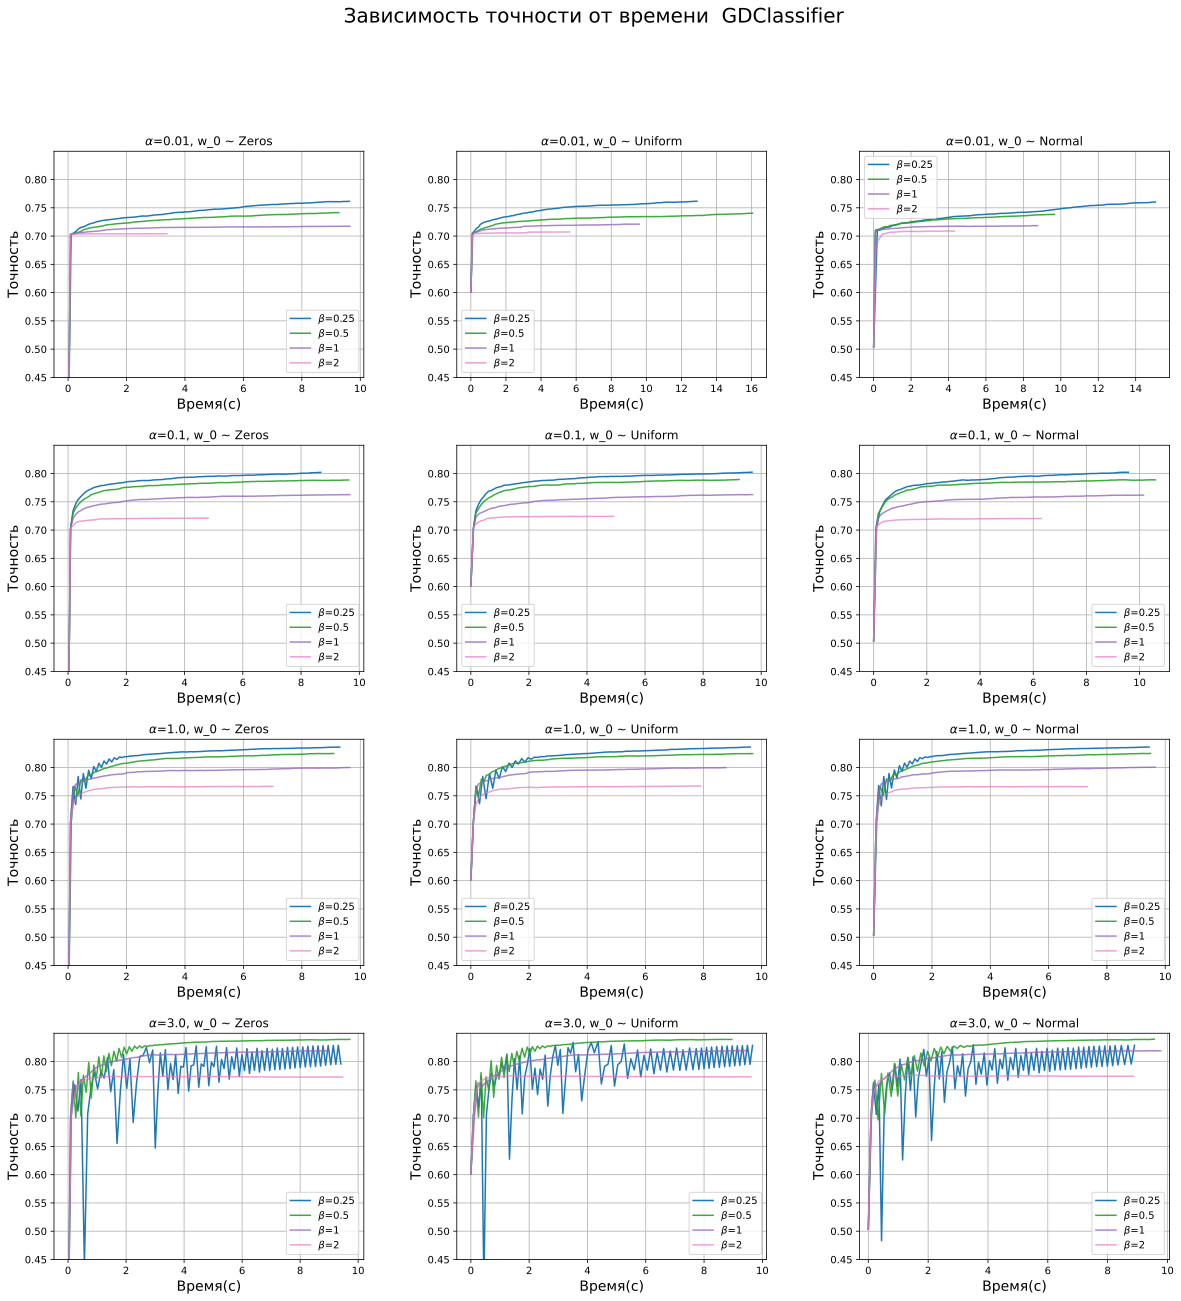

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 3, figsize=(3,4))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('tab20')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость точности от времени  GDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, w_0_name in enumerate(w_0_names):
    for j, beta in enumerate(step_betas):
        ax[i,k].plot(all_history_gd[alpha][k][beta]['plot_time'], all_history_gd[alpha][k][beta]['acc'], label=r'$\beta$' + f"={beta}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ w_0_name)
    ax[i,k].set_xlabel('Время(с)', fontsize=14)
    ax[i,k].set_ylim([0.45,0.85])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.45, 0.85, 0.05))
    ax[i,k].set_ylabel('Точность', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_4_acc_time.svg", bbox_inches='tight')
plt.show()

лучшие параметры alpha=1, beta=0.25, w_0~Uniform

# 5.Исследование стохастического градиентного спуска

### Перебор гипрпараметров всевозможных комбинаций

In [ ]:
l2_coef = 0.01
num_size = X_train.shape[1]
step_alphas = [0.01, 0.1, 1.0, 3.0]
step_betas = [2 ** i for i in range(-2,2)]
w_0_types = [np.zeros(num_size), np.random.uniform(-1/num_size, 1/num_size, num_size), np.random.normal(0, 1/num_size, num_size)]
all_history_sgd = dict()
batch_sizes = [500, 1000, 2500, 5000, 10000]

for alpha in step_alphas:
  all_history_sgd[alpha] = dict()
  for beta in step_betas:
    all_history_sgd[alpha][beta] = dict()
    for batch_size in batch_sizes:
      all_history_sgd[alpha][beta][batch_size] = dict()
      model = SGDClassifier(loss_function='binary_logistic',batch_size=batch_size, step_alpha=alpha, step_beta=beta, max_iter=100, l2_coef=l2_coef)
      all_history_sgd[alpha][beta][batch_size] = model.fit(X_train, y_train, trace=True, if_acc=True, X_test=X_test, y_test=y_test,log_freq=0.5)
      print(f"alpha={alpha}, beta={beta}, batch_size={batch_size}")

alpha=0.01, beta=0.25, batch_size=500
alpha=0.01, beta=0.25, batch_size=1000
alpha=0.01, beta=0.25, batch_size=2500
alpha=0.01, beta=0.25, batch_size=5000
alpha=0.01, beta=0.25, batch_size=10000
alpha=0.01, beta=0.5, batch_size=500
alpha=0.01, beta=0.5, batch_size=1000
alpha=0.01, beta=0.5, batch_size=2500
alpha=0.01, beta=0.5, batch_size=5000
alpha=0.01, beta=0.5, batch_size=10000
alpha=0.01, beta=1, batch_size=500
alpha=0.01, beta=1, batch_size=1000
alpha=0.01, beta=1, batch_size=2500
alpha=0.01, beta=1, batch_size=5000
alpha=0.01, beta=1, batch_size=10000
alpha=0.01, beta=2, batch_size=500
alpha=0.01, beta=2, batch_size=1000
alpha=0.01, beta=2, batch_size=2500
alpha=0.01, beta=2, batch_size=5000
alpha=0.01, beta=2, batch_size=10000
alpha=0.1, beta=0.25, batch_size=500
alpha=0.1, beta=0.25, batch_size=1000
alpha=0.1, beta=0.25, batch_size=2500
alpha=0.1, beta=0.25, batch_size=5000
alpha=0.1, beta=0.25, batch_size=10000
alpha=0.1, beta=0.5, batch_size=500
alpha=0.1, beta=0.5, batch_si

<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


alpha=3.0, beta=0.25, batch_size=500
alpha=3.0, beta=0.25, batch_size=1000
alpha=3.0, beta=0.25, batch_size=2500
alpha=3.0, beta=0.25, batch_size=5000
alpha=3.0, beta=0.25, batch_size=10000
alpha=3.0, beta=0.5, batch_size=500
alpha=3.0, beta=0.5, batch_size=1000
alpha=3.0, beta=0.5, batch_size=2500
alpha=3.0, beta=0.5, batch_size=5000
alpha=3.0, beta=0.5, batch_size=10000
alpha=3.0, beta=1, batch_size=500
alpha=3.0, beta=1, batch_size=1000
alpha=3.0, beta=1, batch_size=2500
alpha=3.0, beta=1, batch_size=5000
alpha=3.0, beta=1, batch_size=10000
alpha=3.0, beta=2, batch_size=500
alpha=3.0, beta=2, batch_size=1000
alpha=3.0, beta=2, batch_size=2500
alpha=3.0, beta=2, batch_size=5000
alpha=3.0, beta=2, batch_size=10000


### Все итерации и функция потерь

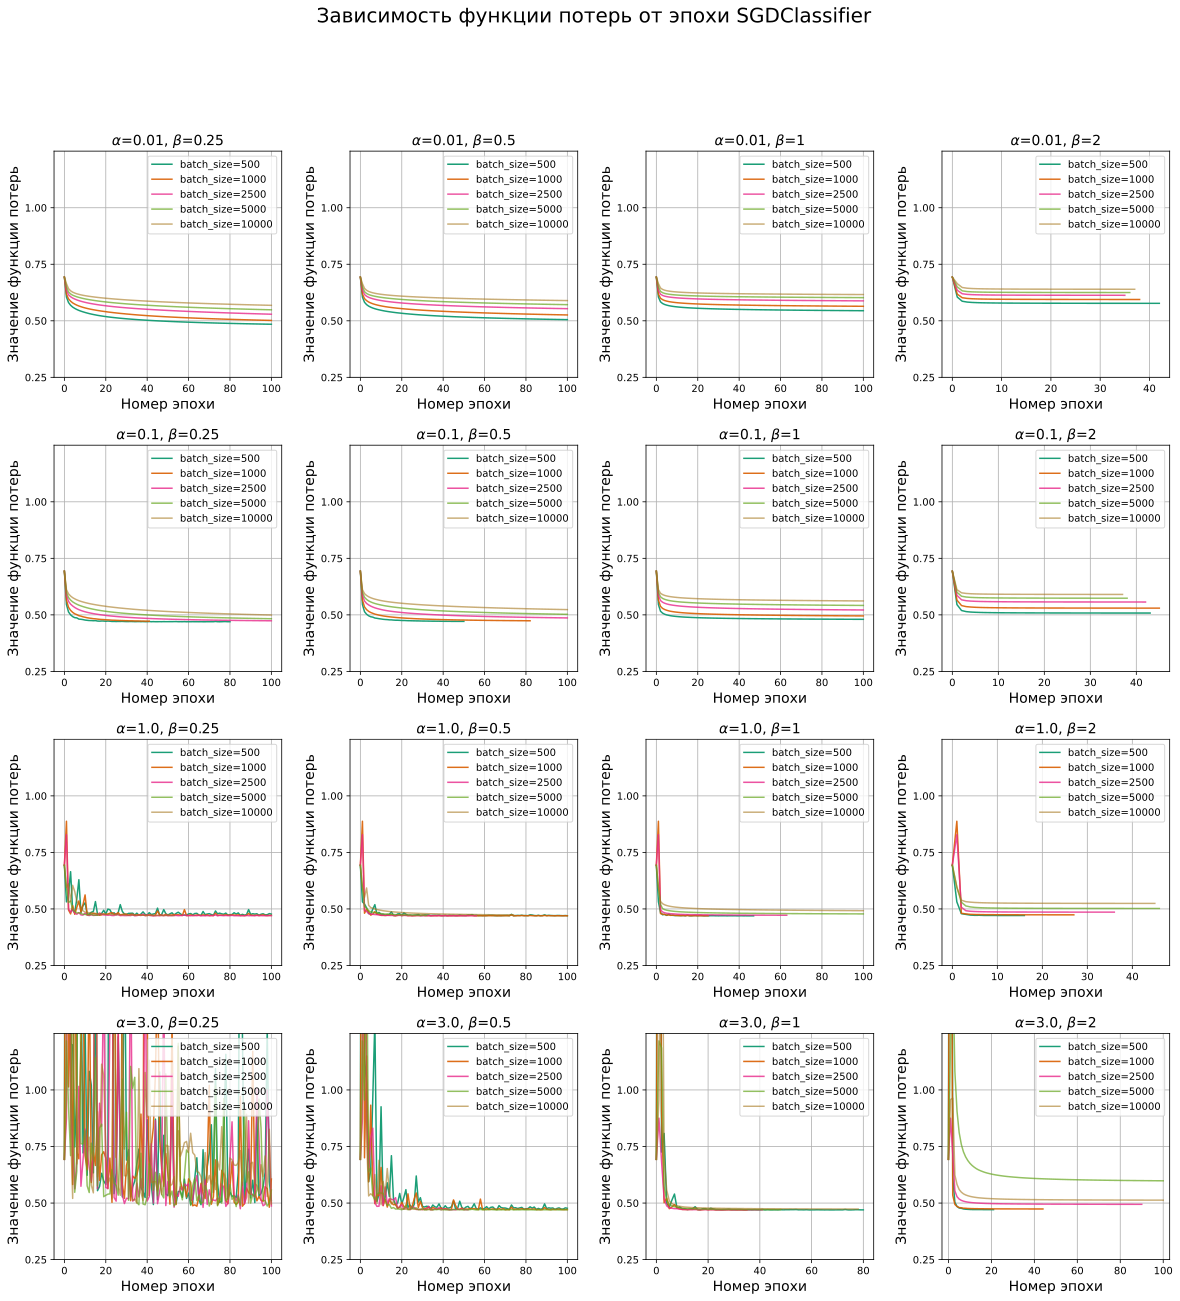

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(3,3))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

batch_sizes = [500, 1000, 2500, 5000, 10000]

fig.suptitle(r'Зависимость функции потерь от эпохи SGDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, beta in enumerate(step_betas):
    for j, batch_size in enumerate(batch_sizes):
        ax[i,k].plot(all_history_sgd[alpha][beta][batch_size]['func'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={beta}',fontsize=14)
    ax[i,k].set_xlabel('Номeр эпохи', fontsize=14)
    ax[i,k].set_ylim([0.25,1.25])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.25, 1.25, 0.25))
    ax[i,k].set_ylabel('Значение функции потерь', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_loss_it.svg", bbox_inches='tight')
plt.show()

### Избранное итерации и функция потерь

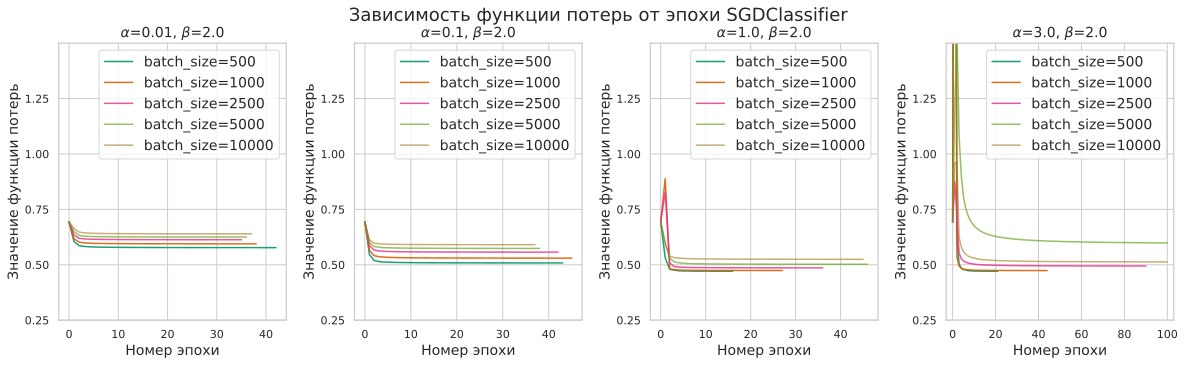

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(3,3))
fig.set_size_inches(20, 5)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость функции потерь от эпохи SGDClassifier', fontsize=18)
for i, alpha in enumerate(step_alphas):
  for j, batch_size in enumerate(batch_sizes):
    ax[i].plot(all_history_sgd[alpha][2][batch_size]['func'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
  ax[i].legend(fontsize=14)
  ax[i].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={2.0}',fontsize=14)
  ax[i].set_xlabel('Номeр эпохи', fontsize=14)
  ax[i].set_ylim([0.25,1.5])
  ax[i].grid(True)
  ax[i].set_yticks(np.arange(0.25, 1.5, 0.25))
  ax[i].set_ylabel('Значение функции потерь', fontsize=14)

plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_loss_it_fix.svg", bbox_inches='tight')
plt.show()

### Все эпохи и точность

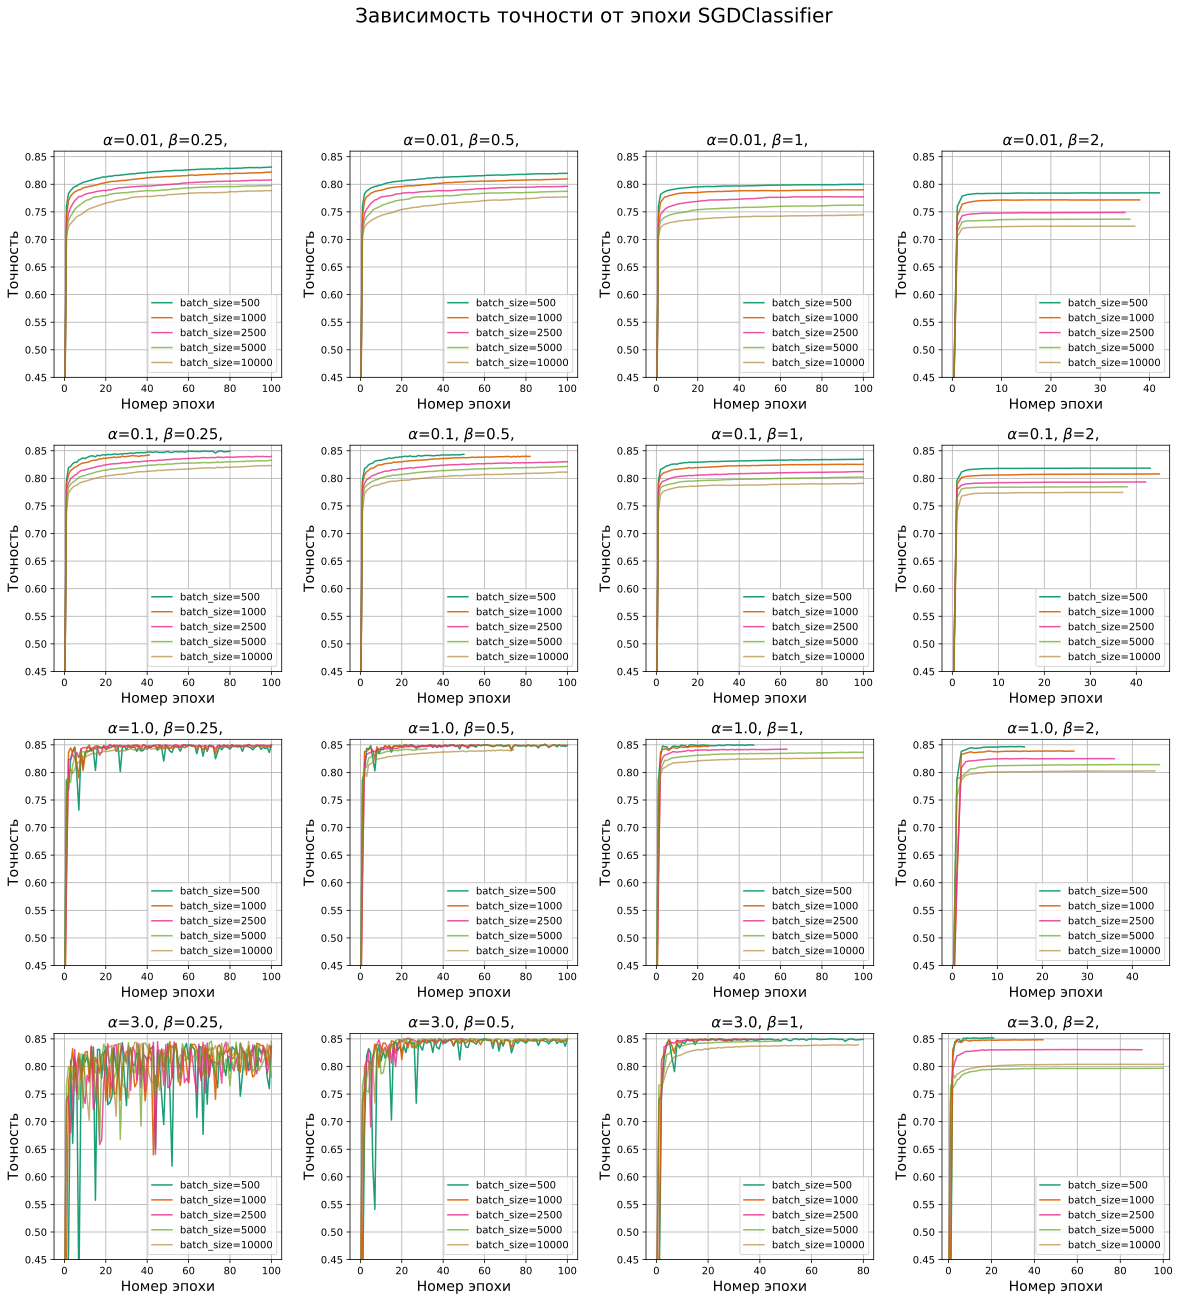

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(3,3))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

batch_sizes = [500, 1000, 2500, 5000, 10000]

fig.suptitle(r'Зависимость точности от эпохи SGDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, beta in enumerate(step_betas):
    for j, batch_size in enumerate(batch_sizes):
        ax[i,k].plot(all_history_sgd[alpha][beta][batch_size]['acc'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={beta}, ',fontsize=15)
    ax[i,k].set_xlabel('Номeр эпохи',fontsize=14)
    ax[i,k].set_ylim([0.45,0.86])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.45, 0.86, 0.05))
    ax[i,k].set_ylabel('Точность',fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_acc_it.svg", bbox_inches='tight')
plt.show()

### Избранное эпохи и точность

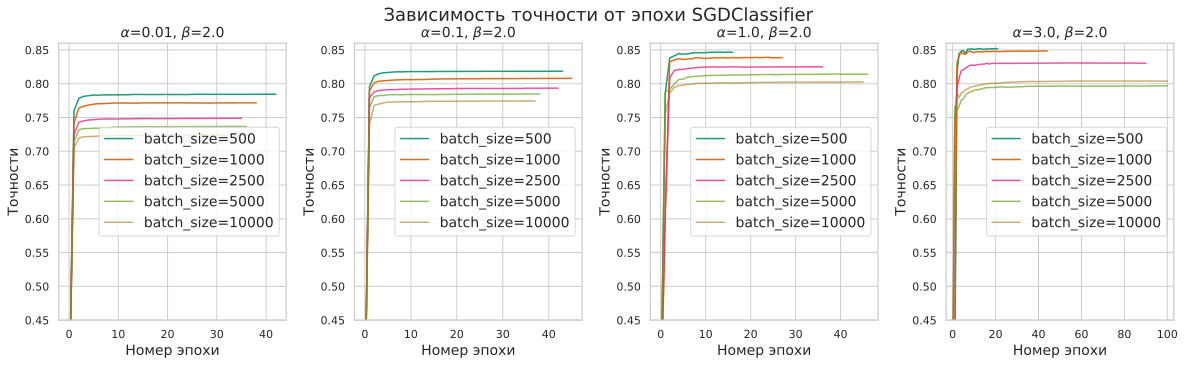

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(3,3))
fig.set_size_inches(20, 5)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
fig.suptitle(r'Зависимость точности от эпохи SGDClassifier', fontsize=18)
for i, alpha in enumerate(step_alphas):
  for j, batch_size in enumerate(batch_sizes):
    ax[i].plot(all_history_sgd[alpha][2][batch_size]['acc'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
  ax[i].legend(fontsize=14, loc='center right')
  ax[i].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={2.0}',fontsize=14)
  ax[i].set_xlabel('Номeр эпохи', fontsize=14)
  ax[i].set_ylim([0.45,0.86])
  ax[i].grid(True)
  ax[i].set_yticks(np.arange(0.45, 0.86, 0.05))
  ax[i].set_ylabel('Точности', fontsize=14)

plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_acc_it_fix.svg", bbox_inches='tight')
plt.show()

### Все время и точность

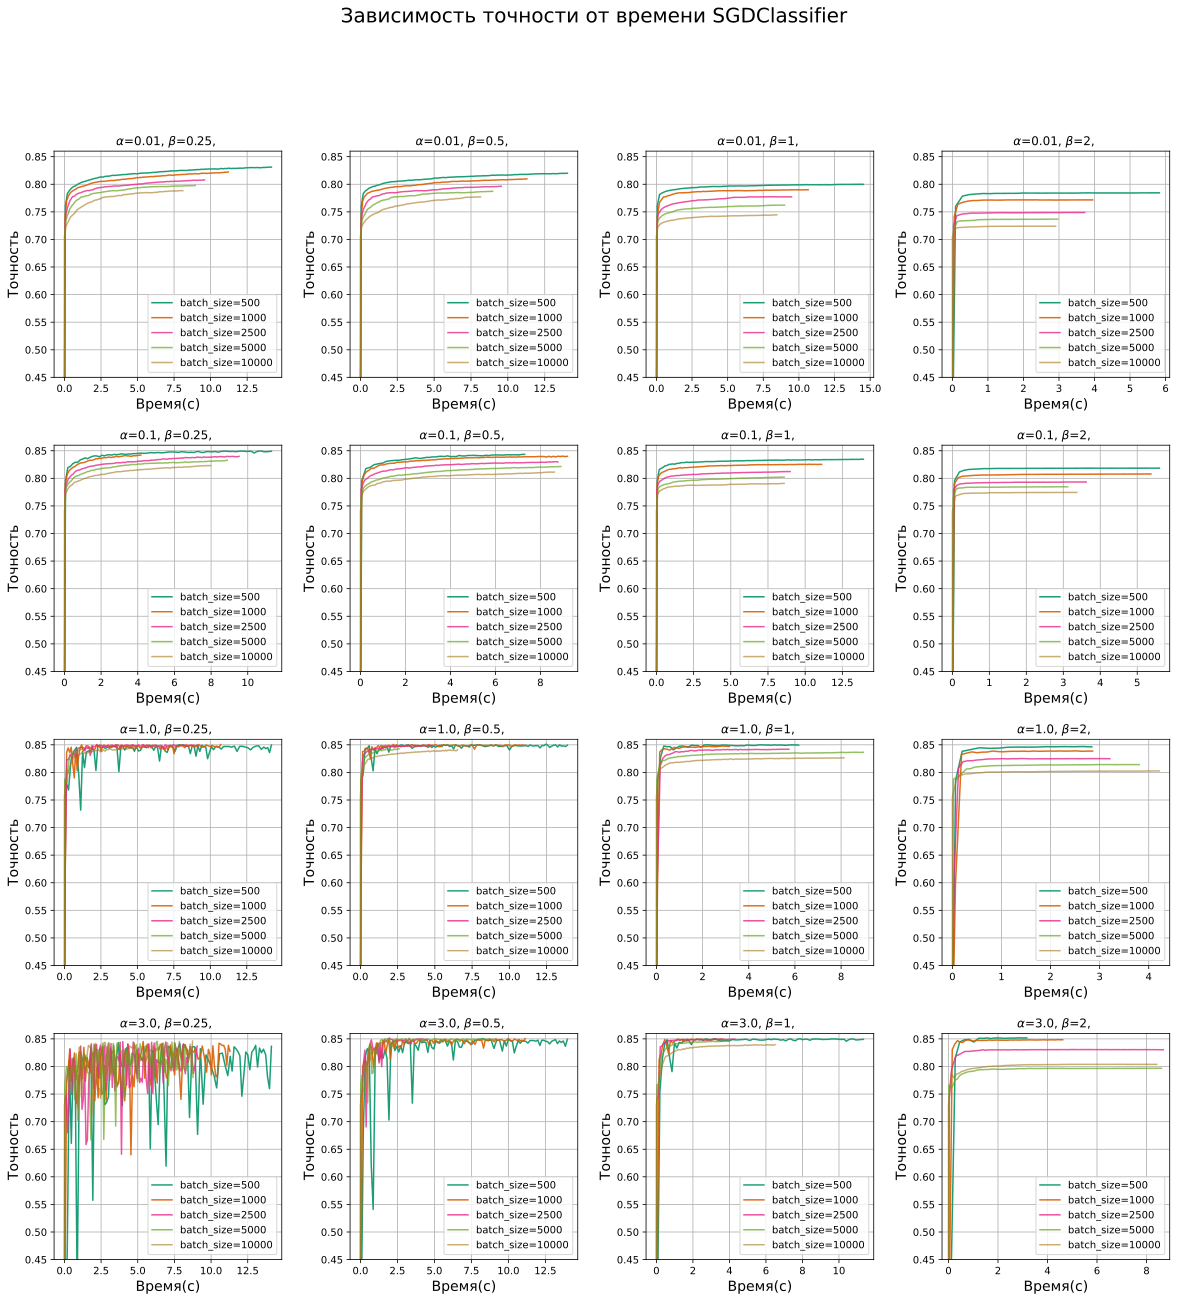

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(3,3))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

batch_sizes = [500, 1000, 2500, 5000, 10000]

fig.suptitle(r'Зависимость точности от времени SGDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, beta in enumerate(step_betas):
    for j, batch_size in enumerate(batch_sizes):
        ax[i,k].plot(all_history_sgd[alpha][beta][batch_size]['plot_time'],all_history_sgd[alpha][beta][batch_size]['acc'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={beta}, ')
    ax[i,k].set_xlabel('Время(с)', fontsize=14)
    ax[i,k].set_ylim([0.45,0.86])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.45, 0.86, 0.05))
    ax[i,k].set_ylabel('Точность', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_acc_time.svg", bbox_inches='tight')
plt.show()

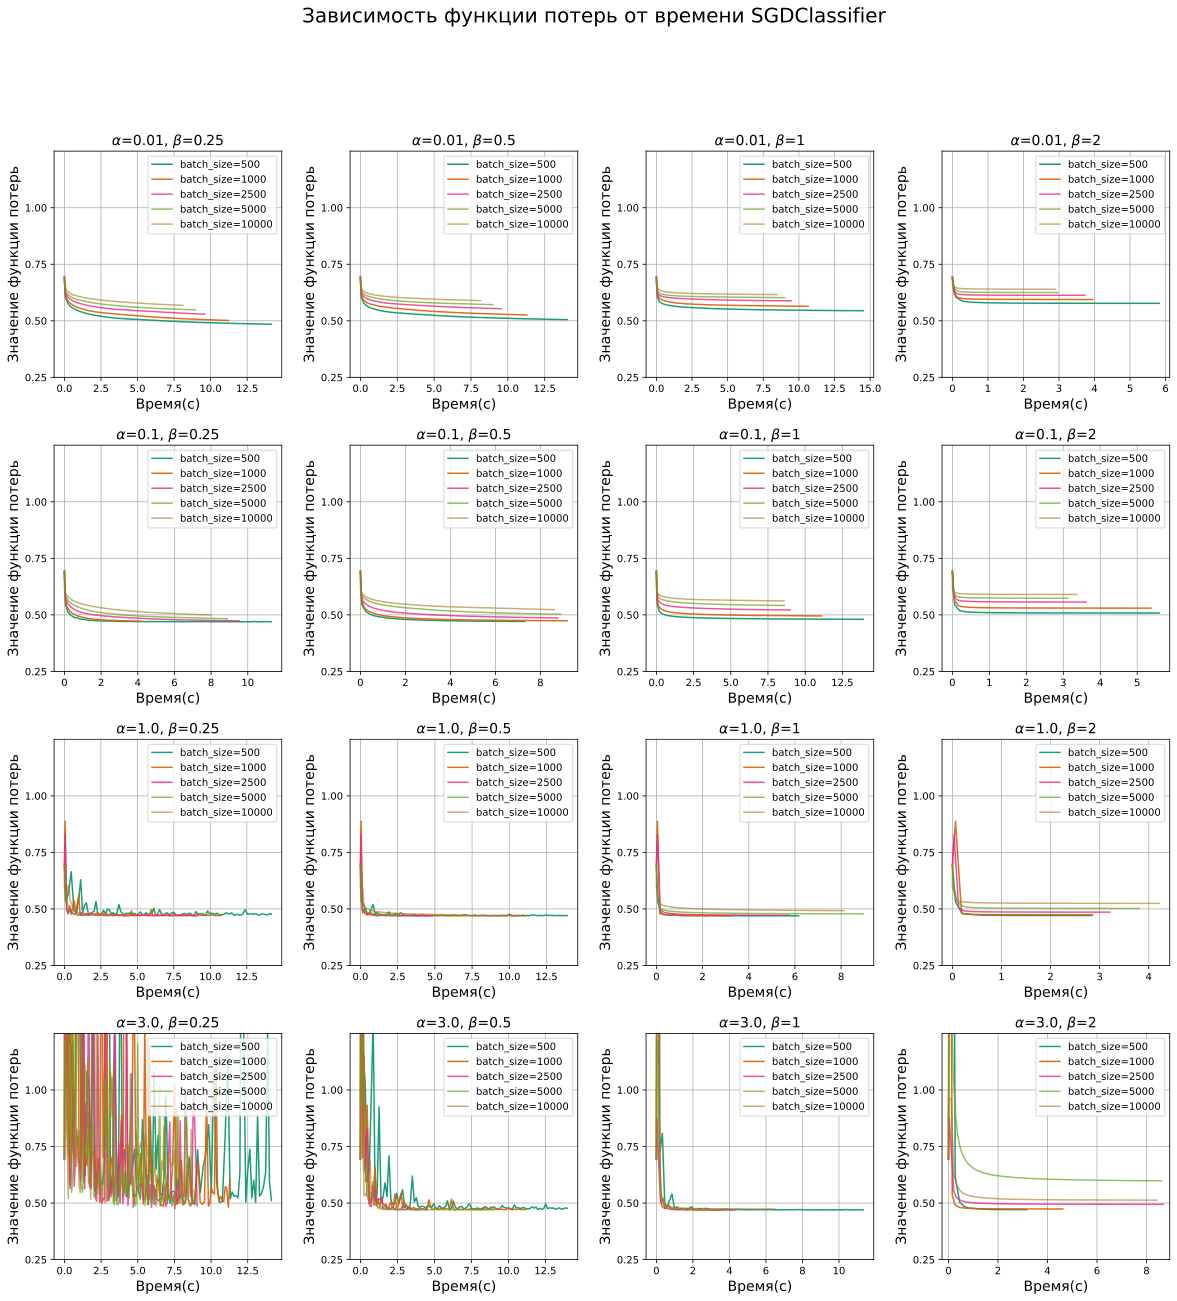

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(3,3))
fig.set_size_inches(20, 20)

cmap = plt.get_cmap('Dark2')

colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

batch_sizes = [500, 1000, 2500, 5000, 10000]

fig.suptitle(r'Зависимость функции потерь от времени SGDClassifier', fontsize=20)
for i, alpha in enumerate(step_alphas):
  for k, beta in enumerate(step_betas):
    for j, batch_size in enumerate(batch_sizes):
        ax[i,k].plot(all_history_sgd[alpha][beta][batch_size]['plot_time'], all_history_sgd[alpha][beta][batch_size]['func'], label=f"batch_size={batch_size}", color=colors[j], alpha = alphas[j])
    ax[i,k].legend()
    ax[i,k].set_title(r'$\alpha$'+ f'={alpha}, '+ r'$\beta$'+ f'={beta}',fontsize=14)
    ax[i,k].set_xlabel('Время(с)', fontsize=14)
    ax[i,k].set_ylim([0.25,1.25])
    ax[i,k].grid(True)
    ax[i,k].set_yticks(np.arange(0.25, 1.25, 0.25))
    ax[i,k].set_ylabel('Значение функции потерь', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_loss_time.svg", bbox_inches='tight')
plt.show()

In [ ]:
history_sgd_beta_w0 = dict()

for i, w_0 in enumerate(w_0_types):
  model = SGDClassifier(loss_function='binary_logistic',batch_size=500, step_alpha=3.0, step_beta=2.0, max_iter=100, l2_coef=0.01)
  history_sgd_beta_w0[i] = model.fit(X_train, y_train, w_0=w_0, trace=True, if_acc=True, X_test=X_test, y_test=y_test,log_freq=0.5)

<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


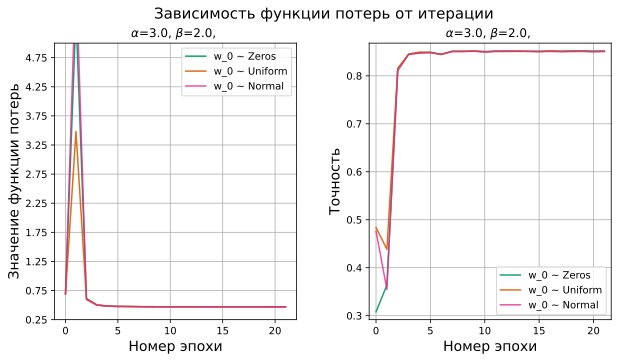

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

cmap = plt.get_cmap('Dark2')

w_0_names = ['w_0 ~ Zeros','w_0 ~ Uniform', 'w_0 ~ Normal']
colors = [cmap(i) for i in np.linspace(0, 1, 6)]
plt.subplots_adjust(wspace=0.3, hspace=0.3)
alphas = [1.0,0.9,0.8, 0.7, 0.6]

batch_sizes = [500, 1000, 2500, 5000, 10000]
data_types = ['func', 'acc']
betas_type = [0.25, 0.5]
fig.suptitle(r'Зависимость функции потерь от эпохи SGDClassifier в зависимости от начального приближения', fontsize=15)
for j, data_type in enumerate(data_types):
    for k, w_0 in enumerate(w_0_types):
      ax[j].plot(history_sgd_beta_w0[k][data_type], label=w_0_names[k], color=colors[k], alpha = alphas[k])
    ax[j].legend()
    ax[j].set_title(r'$\alpha$'+ f'={3.0}, '+ r'$\beta$'+ f'={2.0}, ')
    if j== 0:
      ax[j].set_xlabel('Номeр эпохи', fontsize=14)
      ax[j].set_ylim([0.25,5])
      ax[j].grid(True)
      ax[j].set_yticks(np.arange(0.25,5, 0.5))
      ax[j].set_ylabel('Значение функции потерь', fontsize=14)
    else:
      ax[j].set_xlabel('Номeр эпохи', fontsize=14)
      ax[j].grid(True)
      #ax[j].set_yticks(np.arange(0, 0.86, 0.05))
      ax[j].set_ylabel('Точность', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_5_w0.svg", bbox_inches='tight')
plt.show()

# 6.Сравнение методов между собой

Сравните поведение двух методов между собой, сделайте выводы.

Из экспериментов 4 и 5, выберем лучшие параметры для каждой из модели:


*   GDClassifier: step_alpha=1.0, step_beta=0.5, w_0 ~ [0...0]
*   SGDClassifier: step_alpha=1.0, step_beta=0.5, w_0 ~ [0...0], batch_size=1000




In [355]:
gd = GDClassifier(loss_function='binary_logistic', step_alpha=3.0, step_beta=0.5, max_iter=100, l2_coef=0.01)
history_gd = gd.fit(X_train, y_train,w_0=np.random.uniform(-1/X_train.shape[1], 1/X_train.shape[1], num_size),  trace=True, if_acc=True, X_test=X_test, y_test=y_test)

<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


In [ ]:
sgd = SGDClassifier(loss_function='binary_logistic',batch_size=500, step_alpha=3.0, step_beta=2.0, max_iter=100, l2_coef=0.01)
history_sgd = sgd.fit(X_train, y_train, w_0=np.random.uniform(-1/X_train.shape[1], 1/X_train.shape[1], num_size), trace=True, if_acc=True, X_test=X_test, y_test=y_test, log_freq=0.5)

<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


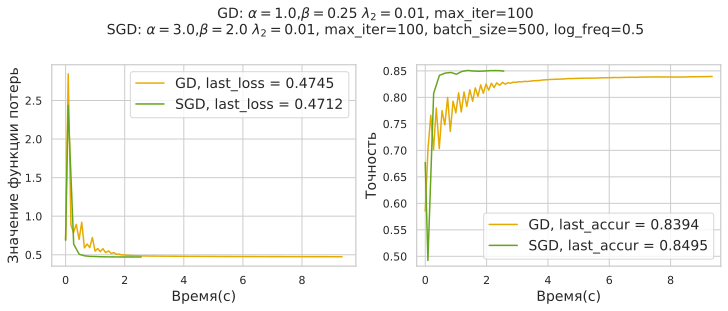

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 8)][0:6][::-1]

alphas = [1.0, 0.8, 0.6]

fig.suptitle(r'GD: $\alpha=1.0$,$\beta=0.25$ $\lambda_2=0.01$, max_iter=100'+'\n' + r'SGD: $\alpha=3.0$,$\beta=2.0$ $\lambda_2=0.01$, max_iter=100, batch_size=500, log_freq=0.5', fontsize=14)
ax = fig.add_subplot(221)
plt.xlabel('Время(с)', fontsize=14)
plt.ylabel('Значение функции потерь', fontsize=14)
plt.grid(True)
#plt.yticks(np.arange(0.5, 6, 0.5))
#plt.xticks(np.arange(0, 160, 25))
plt.plot(history_gd['plot_time'], history_gd['func'], color= colors[0], label=f"GD, last_loss = {history_gd['func'][-1]:.4f}")
plt.plot(history_sgd['plot_time'], history_sgd['func'], color= colors[1], label=f"SGD, last_loss = {history_sgd['func'][-1]:.4f}")
plt.legend(fontsize = 14)


ax = fig.add_subplot(222)
plt.xlabel('Время(с)', fontsize=14)
plt.ylabel('Точность', fontsize=14)
plt.grid(True)

plt.plot(history_gd['plot_time'], history_gd['acc'], color= colors[0], label=f"GD, last_accur = {history_gd['acc'][-1]:.4f}")
plt.plot(history_sgd['plot_time'], history_sgd['acc'], color= colors[1], label=f"SGD, last_accur = {history_sgd['acc'][-1]:.4f}")
plt.legend(fontsize = 14)


plt.margins(x=0.03, y=0.03)
plt.savefig("e_6.svg", bbox_inches='tight')
plt.show()

# 7.Лемматизация

Примените алгоритм лемматизации (например, WordNetLemmatizer из библотеки nltk) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из nltk). Исследуйте, как предобработка корпуса повлияла на точность классификации, время работы алгоритма и размерность признакового пространства.



---

Можно выделить следующие этапы:

*   Удаление специфичных символов/последовательностей
*   Приведение к нижнему регистру

*   Токенизация
*   Лемматизация


*   Выделение коллокаций
*   Удаление стоп-слов / Сокращение словаря


Почти всегда правильная обработка приводит к улучшению качества и уменьшению времени работы.


---










In [ ]:
train_data = pd.read_csv('train.csv', index_col=0)

In [ ]:
import re

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', text)

    return text.strip()

In [ ]:
train_data.iloc[:,0] = train_data.iloc[:,0].apply(preprocess_text)

In [ ]:
target_train = train_data['is_toxic'].copy()
train = train_data.drop('is_toxic', axis=1)

In [ ]:
# => (0,1) -> (-1,1)
target_train = target_train.values.astype(int) * 2 - 1

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('punkt')
def simple_tokenizer(sentence):
    return nltk.tokenize.TreebankWordTokenizer().tokenize(sentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.corpus import wordnet
# код для определения части речи
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN

In [ ]:
from nltk import WordNetLemmatizer
# лемматизация
def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sentence
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in nltk.pos_tag(tokenized_sent)
    ]
    return [
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ]

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return ' '.join([token for token in tokens if token.lower() not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_lem = train.copy()

In [ ]:
train_lem['tokenized_text'] = train_lem['comment_text'].apply(simple_tokenizer)

In [ ]:
train_lem['lemmatized_text'] = train_lem['tokenized_text'].apply(simple_lemmatizer)

In [ ]:
train_lem['final_tokens'] = train_lem['lemmatized_text'].apply(remove_stop_words) # 5min in total

In [ ]:
train_lem_final = train_lem.drop(['tokenized_text', 'comment_text','lemmatized_text' ], axis=1)

In [ ]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(train_lem_final, target_train, train_size=0.7, random_state=241)

In [ ]:
vectorizer_lem = CountVectorizer(min_df=0.01)
X_train_lem_vect =  vectorizer.fit_transform(X_train_lem['final_tokens'])
X_test_lem_vect = vectorizer.transform(X_test_lem['final_tokens'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(train, target_train, train_size=0.7, random_state=241)
vectorizer = CountVectorizer(min_df=0.01)
X_train_vect7 = vectorizer.fit_transform(X_train_7['comment_text'])
X_test_vect7 = vectorizer.transform(X_test_7['comment_text'])

In [ ]:
l2_coef=0.01
def stat_gd_sgd(X_train, y_train, X_test, y_test):
  gd = GDClassifier(loss_function='binary_logistic', step_alpha=1.0, step_beta=0.25, max_iter=100, l2_coef=l2_coef)
  history_gd = gd.fit(X_train, y_train,w_0=np.random.uniform(-1/X_train.shape[1], 1/X_train.shape[1], X_train.shape[1]),  trace=True, if_acc=True, X_test=X_test, y_test=y_test)
  sgd = SGDClassifier(loss_function='binary_logistic',batch_size=500, step_alpha=3.0, step_beta=2.0, max_iter=100, l2_coef=l2_coef)
  history_sgd = sgd.fit(X_train, y_train, w_0=np.random.uniform(-1/X_train.shape[1], 1/X_train.shape[1], X_train.shape[1]), trace=True, if_acc=True, X_test=X_test, y_test=y_test, log_freq=0.5)
  return history_gd, history_sgd

In [360]:
X_train_lem_vect.shape

(36442, 452)

In [362]:
X_test_lem_vect.shape

(15619, 452)

In [364]:
X_train_vect7.shape

(36442, 572)

In [ ]:
history_gd_lem, history_sgd_lem = stat_gd_sgd(X_train_lem_vect, y_train_lem, X_test_lem_vect, y_test_lem) # обработка

In [ ]:
history_gd_vect, history_sgd_vect = stat_gd_sgd(X_train_vect7, y_train_7, X_test_vect7, y_test_7) #без

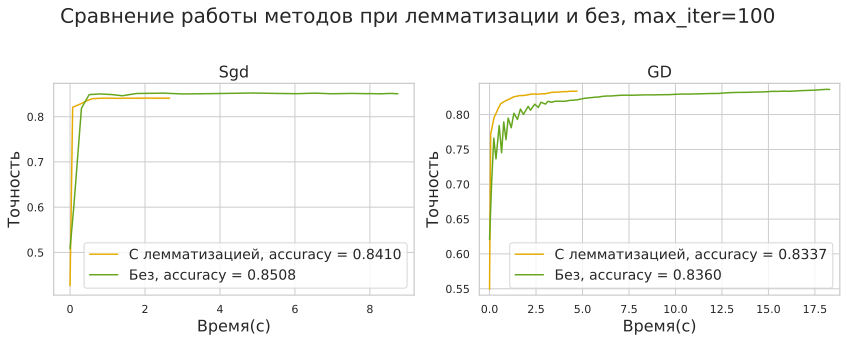

In [359]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(12,8))

cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 8)][0:6][::-1]

alphas = [1.0, 0.8, 0.6]

fig.suptitle('Сравнение работы методов при лемматизации и без, max_iter=100 ', fontsize=20)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax = fig.add_subplot(221)
ax.set_title(r'Sgd', fontsize=16)
plt.xlabel('Время(c)', fontsize=16)
plt.ylabel('Точность', fontsize=16)
plt.grid(True)
plt.plot(history_sgd_lem['plot_time'],history_sgd_lem['acc'], color= colors[0], label=f"С лемматизацией, accuracy = {history_sgd_lem['acc'][-1]:.4f}")
plt.plot(history_sgd_vect['plot_time'],history_sgd_vect['acc'], color= colors[1], label=f"Без, accuracy = {history_sgd_vect['acc'][-1]:.4f}")
plt.legend(fontsize = 14)


ax = fig.add_subplot(222)
ax.set_title(r'GD', fontsize=16)
plt.xlabel('Время(c)', fontsize=16)
plt.ylabel('Точность', fontsize=16)
plt.grid(True)
plt.plot(history_gd_lem['plot_time'], history_gd_lem['acc'], color= colors[0], label=f"С лемматизацией, accuracy = {np.mean(history_gd_lem['acc'][-1]):.4f}")
plt.plot(history_gd_vect['plot_time'], history_gd_vect['acc'], color= colors[1], label=f"Без, accuracy = {np.mean(history_gd_vect['acc'][-1]):.4f}")
plt.legend(fontsize = 14)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.margins(x=0.03, y=0.03)
plt.savefig("e_7.svg", bbox_inches='tight')
plt.show()

In [ ]:
print(f"С лемматизацией")
print(f"GD:время работы {history_gd_lem['plot_time'][-1]:.5f}, итоговая точность {history_gd_lem['acc'][-1]:.5f}, функция потерь {history_gd_lem['func'][-1]:.5f}")
print(f"SGD:время работы {history_sgd_lem['plot_time'][-1]:.5f}, итоговая точность {history_sgd_lem['acc'][-1]:.5f}, функция потерь {history_sgd_lem['func'][-1]:.5f}")

С лемматизацией
GD:время работы 4.70067, итоговая точность 0.83366, функция потерь 0.50758
SGD:время работы 2.65453, итоговая точность 0.84096, функция потерь 0.49754


In [ ]:
print(f"Без")
print(f"GD:время работы {history_gd_vect['plot_time'][-1]:.5f}, итоговая точность {history_gd_vect['acc'][-1]:.5f}, функция потерь {history_gd_vect['func'][-1]:.5f}")
print(f"SGD:время работы {history_sgd_vect['plot_time'][-1]:.5f}, итоговая точность {history_sgd_vect['acc'][-1]:.5f}, функция потерь {history_sgd_vect['func'][-1]:.5f}")

Без
GD:время работы 18.29114, итоговая точность 0.83603, функция потерь 0.47881
SGD:время работы 8.74299, итоговая точность 0.85076, функция потерь 0.47069


# 8.BagOfWords или Tfidf

Исследуйте качество, время работы алгоритма и размер признакового пространства в зависимости от следуюших факторов:

*   использовалось представление BagOfWords или Tfidf
*   параметров min_df и max_df конструкторов.


**Замечание**. Для построения tf-idf представления воспользуйтесь TfidfTransformer или TfidfVectorizer из библиотеки sklearn.


In [ ]:
import re

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', text)

    return text.strip()

train_data = pd.read_csv('train.csv', index_col=0)
train_data.iloc[:,0] = train_data.iloc[:,0].apply(preprocess_text)
target_train = train_data['is_toxic'].copy()
target_train = target_train.values.astype(int) * 2 - 1
train = train_data.drop('is_toxic', axis=1)
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(train, target_train, train_size=0.7, random_state=241)

In [ ]:
l2_coef=0.01
def stat_sgd(X_train, y_train, X_test, y_test):
  sgd = SGDClassifier(loss_function='binary_logistic', batch_size=500, step_alpha=3.0, step_beta=2.0, max_iter=300, l2_coef=l2_coef)
  history_sgd = sgd.fit(X_train, y_train, w_0=np.random.uniform(-1/X_train.shape[1], 1/X_train.shape[1], X_train.shape[1]), trace=True, if_acc=True, X_test=X_test, y_test=y_test, log_freq=0.5)
  return history_sgd

In [ ]:
min_dfs = [0.0001, 0.001, 0.01]
max_dfs = [0.35, 0.65, 0.95]

In [ ]:
accuracy_bow = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0) #0-gd, 1-sgd
time_bow = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0)
size_bow = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0)

In [ ]:
accuracy_tfidf = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0) #0-gd, 1-sgd
time_tfidf = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0)
size_tfidf = pd.DataFrame(index=max_dfs, columns=min_dfs).fillna(0)

In [ ]:
X_train_8.shape

(36442, 1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


for max_df in max_dfs:
    for min_df in min_dfs:

        bow_vect = CountVectorizer(min_df=min_df, max_df=max_df)

        X_train_bow = bow_vect.fit_transform(X_train_8['comment_text'])
        X_test_bow = bow_vect.transform(X_test_8['comment_text'])

        history_sgd_bow = stat_sgd(X_train_bow, y_train, X_test_bow, y_test)

        accuracy_bow.at[max_df,min_df], time_bow.at[max_df,min_df], size_bow.at[max_df,min_df] = history_sgd_bow['acc'][-1], history_sgd_bow['plot_time'][-1], X_train_bow.shape[1]

        tf_vect = TfidfVectorizer(min_df=min_df, max_df=max_df, norm=None)

        X_train_tfidf = tf_vect.fit_transform(X_train_8['comment_text'])
        X_test_tfidf = tf_vect.transform(X_test_8['comment_text'])

        history_sgd_tfidf = stat_sgd(X_train_tfidf, y_train_8, X_test_tfidf, y_test_8)

        accuracy_tfidf.at[max_df,min_df], time_tfidf.at[max_df,min_df], size_tfidf.at[max_df,min_df] = history_sgd_tfidf['acc'][-1], history_sgd_tfidf['plot_time'][-1], X_train_tfidf.shape[1]


<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


In [ ]:
ind_last = [f"{i}\n {j}" for i in max_dfs for j in min_dfs if (i!=0 and j !=0)]
#ind_last[0] = f"max_df: {max_dfs[0]}\n min_df: {min_dfs[0]}"

In [ ]:
data_frame_to_plot_time = pd.DataFrame(index=ind_last, columns=['sgd_bow', 'sgd_tfidf'])

In [ ]:
data_frame_to_plot = pd.DataFrame(index=ind_last,columns=['sgd_bow', 'sgd_tfidf'] )

In [ ]:
data_frame_to_plot_size = pd.DataFrame(index=ind_last,columns=['sgd_bow', 'sgd_tfidf'] )

In [ ]:
columns_range = ['sgd_bow', 'sgd_tfidf']
i=0
for num, ind in enumerate(data_frame_to_plot.index):
  if i%3 == 0:
      time_bow_sgd = time_bow.loc[max_dfs[i//3]].values
      time_tf_sgd = time_tfidf.loc[max_dfs[i//3]].values
  data_frame_to_plot_time.loc[ind] = time_bow_sgd[num % 3],time_tf_sgd[num % 3]
  i+=1

In [ ]:
columns_range = ['sgd_bow', 'sgd_tfidf']
i=0
for num, ind in enumerate(data_frame_to_plot.index):
  if i%3 == 0:
    accuracy_bow_sgd = accuracy_bow.loc[max_dfs[i//3]].values
    accuracy_tf_sgd = accuracy_tfidf.loc[max_dfs[i//3]].values
  data_frame_to_plot.loc[ind] = accuracy_bow_sgd[num % 3], accuracy_tf_sgd[num % 3]
  i+=1

In [ ]:
columns_range = ['sgd_bow', 'sgd_tfidf']
i=0
for num, ind in enumerate(data_frame_to_plot.index):
  if i%3 == 0:
    size_bow_sgd = size_bow.loc[max_dfs[i//3]].values
    size_tf_sgd = size_tfidf.loc[max_dfs[i//3]].values
  data_frame_to_plot_size.loc[ind] = size_bow_sgd[num % 3], size_tf_sgd[num % 3]
  i+=1

In [ ]:
data_frame_to_plot_time = data_frame_to_plot_time.astype(float)
data_frame_to_plot = data_frame_to_plot.astype(float)
data_frame_to_plot_size = data_frame_to_plot_size.astype(float)

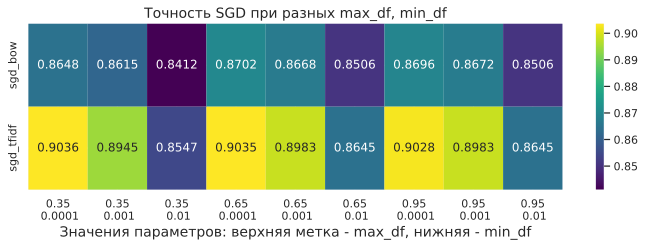

In [ ]:
plt.figure(figsize=(12, 3))
sns.set(font_scale=1)
sns.heatmap(data_frame_to_plot.T, annot=True, cmap='viridis', fmt='.4f')

# Добавляем заголовок
plt.title('Точность SGD при разных max_df, min_df', fontsize=14)
plt.xlabel('Значения параметров: верхняя метка - max_df, нижняя - min_df', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_8_acc.svg", bbox_inches='tight')
plt.show()

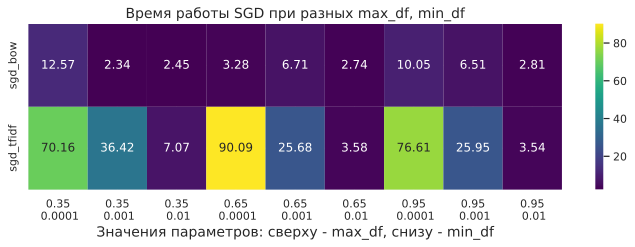

In [ ]:
plt.figure(figsize=(12, 3))
sns.set(font_scale=1)
sns.heatmap(data_frame_to_plot_time.T, annot=True, cmap='viridis', fmt='.2f')

# Добавляем заголовок
plt.title('Время работы SGD при разных max_df, min_df',fontsize=14)
plt.xlabel('Значения параметров: сверху - max_df, cнизу - min_df',fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_8_t.svg", bbox_inches='tight')
plt.show()

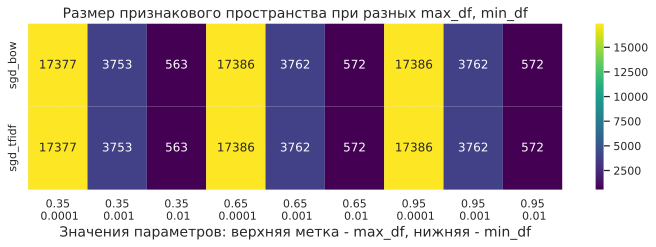

In [365]:
plt.figure(figsize=(12, 3))
sns.set(font_scale=1)
sns.heatmap(data_frame_to_plot_size.T, annot=True, cmap='viridis', fmt=".0f")

# Добавляем заголовок
plt.title('Размер признакового пространства при разных max_df, min_df', fontsize=14)
plt.xlabel('Значения параметров: верхняя метка - max_df, нижняя - min_df', fontsize=14)
plt.margins(x=0.03, y=0.03)
plt.savefig("e_8_size.svg", bbox_inches='tight')
plt.show()

Лучший алгоритм -> sgd_tfidf(0.001, )

# 9.Лучший алгоритм для тестовой выборки

Выберите лучший алгоритм для тестовой выборки.Проанализируйте ошибки алгоритма.Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки.

In [395]:
import re

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^0-9A-Za-zА-Яа-яЁё]', ' ', text)

    return text.strip()

train_data = pd.read_csv('train.csv', index_col=0)
train_data.iloc[:,0] = train_data.iloc[:,0].apply(preprocess_text)
target_train = train_data['is_toxic'].copy()
target_train = target_train.values.astype(int) * 2 - 1
train = train_data.drop('is_toxic', axis=1)

In [397]:
test_data = pd.read_csv('test.csv', index_col=0)
test_data.iloc[:,0] = test_data.iloc[:,0].apply(preprocess_text)
target_test = test_data['is_toxic'].copy()
target_test = target_test.values.astype(int) * 2 - 1
test = test_data.drop('is_toxic', axis=1)

In [398]:
tf_vect_best = TfidfVectorizer(min_df=0.0001,max_df=0.35, norm=None)

train_tfidf = tf_vect.fit_transform(train['comment_text'])
test_tfidf = tf_vect.transform(test['comment_text'])


In [402]:
best_model = SGDClassifier(loss_function='binary_logistic',batch_size=500, step_alpha=3.0, step_beta=2.0, max_iter=10000, l2_coef=0.01)
history_best = best_model.fit(train_tfidf, target_train, w_0=np.random.uniform(-1/train_tfidf.shape[1], 1/train_tfidf.shape[1], train_tfidf.shape[1]), trace=True, if_acc=True, X_test=test_tfidf, y_test=target_test, log_freq=0.5)


<ipython-input-2-dee2058a556f>:43: RuntimeWarning: overflow encountered in exp
  diff = np.clip(np.exp(to_exp), min_val, max_val)


In [403]:
y_pred = best_model.predict(test_tfidf)

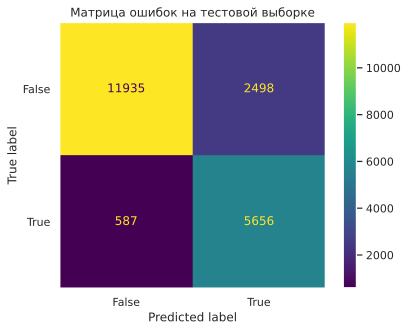

In [410]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
cm = confusion_matrix(target_test, y_pred, labels=[-1, 1])
matr = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
matr.plot()
plt.title("Матрица ошибок на тестовой выборке")
plt.margins(x=0.03, y=0.03)
plt.savefig("e_9.svg", bbox_inches='tight')
plt.show()

In [405]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


accuracy = accuracy_score(target_test, y_pred)
precision = precision_score(target_test, y_pred)
recall = recall_score(target_test, y_pred)


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8508
Precision: 0.6936
Recall: 0.9060


In [434]:
fp_inds = (y_pred == 1) & (target_test == -1)

In [418]:
y_proba = best_model.predict_proba(test_tfidf)

In [464]:
sorted_indices = np.argsort(-y_proba[fp_inds][:,1])

In [465]:
sorted_indices

array([1894, 1013, 2352, ..., 1769, 1000, 1662])

In [469]:
y_proba[fp_inds][:30]

array([[2.11744361e-01, 7.88255639e-01],
       [2.61183229e-01, 7.38816771e-01],
       [5.00000000e-01, 5.00000000e-01],
       [5.48077913e-05, 9.99945192e-01],
       [2.51012949e-01, 7.48987051e-01],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01],
       [3.17202443e-01, 6.82797557e-01],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01],
       [4.00784026e-01, 5.99215974e-01],
       [3.34289502e-01, 6.65710498e-01],
       [1.65962110e-01, 8.34037890e-01],
       [4.80633648e-03, 9.95193664e-01],
       [2.40207068e-01, 7.59792932e-01],
       [3.64926318e-01, 6.35073682e-01],
       [1.44556828e-01, 8.55443172e-01],
       [4.79243414e-01, 5.20756586e-01],
       [4.22156851e-01, 5.77843149e-01],
       [9.70124456e-02, 9.02987554e-01],
       [5.01179150e-02, 9.49882085e-01],
       [4.75270019e-01, 5.24729981e-01],
       [5.00000000e-01, 5.00000000e-01],
       [4.05486006e-01, 5.94513994e-01],
       [1.199285

In [468]:
test[(y_pred == 1) & (target_test == -1)].head(30)

comment_text
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [470]:
fn_inds = (y_pred == -1) & (target_test == 1)

In [472]:
test_data[fn_inds].head(20)

comment_text  \
38                                                                                                                                                                                                                                                                                                                                                                                                                                     how dare you vandalize that page about the hms beagle  don t vandalize again  demon   
237                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              if ya not    still fu k u   
294                                                                                                                                                                                                                                                                                                                                                                                                                                                                give blowjobs to hot women from alderley edge  cheshire   
434                                                                                                                                                                                                                                                                                                                                                                                                                                                that s helpful  mos be damned  thecodingproject thinks it s  10x  worse   
484                                                                                                                                                                                                                                                                                                                                                                                                                                                     intolerance in india        india is a generator of liars like you   
541                                                                                    because the overall aim of the project is worth putting up with this for       because there is sometimes some personal learning involved in the topic research  which is itself a worthwhile goal       otherwise no reason  you can put up with the shit if you wish to  it s not usually too onerous  even the idiocy isn t too painful   you re only required to make the show of being civil to the fools  not to respect them   
655                                                                                                                                                                                                                                                                                                                          utterly utterly tiny insignificant anal retentive thing  but   it s later learned that dan marino was about to be kidnap and join with snowflake    you missed a   ped   at the end of kidnap   
833                                                                                                                                                                                                                                                                                                                                  someone  please edit this line       the lebanon operation  u s  army center for military

# Источники

[Ноутбук семинара 2022-2023](https://colab.research.google.com/github/mmp-practicum-team/mmp_practicum_fall_2022/blob/main/Seminars/08-text-processing-and-logreg/text_processing.ipynb#scrollTo=Ea2ZMq8hn6zN)